In [ ]:
# THIS CODE TAKES 28X28 IMAGES WITH RANDOM ELLIPSOIDS AND ADDED NOISE, TRAINS A NETWORK WITH THEM AND USES THIS NETWORK TO DENOISE OTHER RANDOM ELLIPSOIDS IMAGES. 
# THE RESULTS ARE COMPARED TO A 10 ITERATION MLEM RECONSTRUCTION OF THE SAME IMAGES AND TO A DENOISING PERFORMED WITH A NETWORK TRAINED WITH MNIST DATABASE IMAGES.

In [1]:
# IMPORT NECESSARY PACKAGES:

import numpy as np
import odlpet # PET imaging module
import odl # Reconstruction module
import torch # Deep learning package
from torch import nn
from torch.nn import functional as F
from torch import optim # Optimizer package
import torchvision
from torchvision import datasets, transforms # Package to manipulate datasets
import matplotlib.pyplot as plt # Plotting package
torch.manual_seed(123);  # reproducibility
from odlpet.scanner.scanner import Scanner # PET scanner package
from odlpet.scanner.compression import Compression
from odl.contrib.torch import OperatorAsModule # Package to convert ODL operators into PyTorch Tensors
import time
from odl.contrib import fom # Figures of merit package from ODL

In [2]:
# DEFINE PET SPACE:
prob_size = 28 # Space size
scanner = Scanner() # PET scanner operator
scanner.det_radius = 25*(prob_size/28)+5 # Detector radius
compression = Compression(scanner) # Compression operator

# Define acquisition parameters
compression.num_of_views = 128 
compression.num_non_arccor_bins = 54

# Obtain the projector data from STIR
pet_projector = compression.get_projector(compression.get_stir_domain(sizes=(1,prob_size,prob_size)),restrict_to_cylindrical_FOV=False) 

In [3]:
pet_projector_adj=pet_projector.adjoint # Compute adjoint operator
pet_projector.range # Get the range of the PET sinogram space

uniform_discr([  0.,   0., -30.], [  1.    ,   3.1416,  30.    ], (1, 128, 54), dtype='float32')

In [4]:
pet_projector.domain # Get the range of the PET image space

uniform_discr([ 0. , -4.2, -4.2], [ 0.675,  4.2  ,  4.2  ], (1, 28, 28), dtype='float32')

In [5]:
# Obtain also the conversion into torch tensors for the forward operator and its adjoint
fwd_op_mod=OperatorAsModule(pet_projector)
fwd_op_adj_mod = OperatorAsModule(pet_projector_adj)

In [6]:
def generate_ellipsoids_2d(space,num=np.random.poisson(20),diag=100):
    
    # Generate a 2D phantom of randomly distributed ellipsoids, using for that purpose a "surrounding" space where these ellipsoids are computed and then cropping this "surrounding" space
    # in the center with a size equal to the one given by the reconstruction space. The number of elipsoids is given by "num" and it is usually randomly distributed with a Poisson distribution

    max_axis=diag**2 # Maximum length of the long axis of the ellipsis

    # Surrounding space:
    surround=odl.uniform_discr([0, 0], [int(np.ceil(np.sqrt(max_axis))),int(np.ceil(np.sqrt(max_axis)))], [int(np.ceil(np.sqrt(max_axis))), int(np.ceil(np.sqrt(max_axis)))],
                              dtype='float32') 

    elipse_image=np.zeros((space.shape[1],space.shape[2])) # Accumulator image with all the valid ellipses



    for i in range(num):
        # Propose possible ellipses in a space surrounding the "real PET space". Consider only those ellipses falling in that "real PET space"
        value=np.random.rand() # Random value for the ellipsis
        angle=np.random.rand()*2*np.pi # Angulation for the elipsis

        if np.sqrt(max_axis)>np.max(pet_projector.domain.shape): # The surrounding space has to be larger than our space. All parameters are random
            x_center=2*np.random.rand()-1 # X center of elipsis
            y_center=2*np.random.rand()-1 # Y center of elipsis
            axis1=np.random.exponential(scale=.5)/1.75 # Long axis of elipsis
            axis2=np.random.exponential(scale=.5)/1.75 # Short axis of elipsis

            if axis2>axis1: # The short axis of the elipsis should in fact be shorter than the long axis. If the opposite happens, recompute until getting a lower short axis
                while axis2>axis1:
                    axis2=np.random.rand()

            elipse=[[value,axis1, axis2,x_center, y_center,angle]] # List of ellipsoid parameters

            el=odl.phantom.geometric.ellipsoid_phantom(surround, elipse).asarray() # Candidate elipse in the surrounding space

            s=np.sum(el[int(np.sqrt(max_axis/2))-int(pet_projector.domain.shape[1]/2):int(np.sqrt(max_axis)/2)+int(pet_projector.domain.shape[1]/2),int(np.sqrt(max_axis)/2)-int(pet_projector.domain.shape[2]/2):int(np.sqrt(max_axis)/2)+int(pet_projector.domain.shape[2]/2)])
            if s>0: # If the sum is larger than 0, the ellipse is accepted and the counter is increased by one unit

                # Save the elipsoid in an accumulator
                elipse_image+=el[int(np.sqrt(max_axis)/2)-int(pet_projector.domain.shape[1]/2):int(np.sqrt(max_axis)/2)+int(pet_projector.domain.shape[1]/2),int(np.sqrt(max_axis)/2)-int(pet_projector.domain.shape[2]/2):int(np.sqrt(max_axis)/2)+int(pet_projector.domain.shape[2]/2)]
        else:
            print('Please introduce a maximum value of the ellipse long axis larger than the size of the reconstruction space in both dimensions')
            break
        
        
    return elipse_image


In [7]:
def ellipse_batch(space, number_of_images,number_of_elipses): # Generate a batch of elipsoid images
    
    images = np.zeros((number_of_images,space.shape[1],space.shape[2])) # Array where the batch with ellipsoid images is saved
    
    for i in range(number_of_images): # Loop going through all the ellipsoid images
        image = generate_ellipsoids_2d(space,number_of_elipses,40) # Function providng an image with random uncentered ellipsoids
        images[i,:,:]=image # Accumulator array of ellipsoid images
             
    return images 

In [8]:
transformations = transforms.Compose([transforms.ToTensor()]) # Set of transformations that can be applied to the dataset

from torch.utils.data.dataset import Dataset

# Build a class to construct a PyTorch dataset with the generated random ellipsoid images

class RandomEllipsoids(Dataset): # Class to produce a Random Ellipsoid dataset either for training or validation
    def __init__(self,space,num_ellipsoids,diag,train=True,transforms=None):
        """
        Args:
            space: image space where to obtain the dataset of ellipsoid images
            num: number of random ellipsoids
            diag: size of surrounding space used to compute ellipsoids outside the center of the FOV
            num_imag: number of images generated
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.space = pet_projector.domain # Reconstruction space
        self.num_ellipsoids= np.random.poisson(10) # Default number of ellipsoids to be contained in the 2D images
        self.diag = diag # Diagonal of the surrounding space to prepare the ellipsoid images
        self.train=train # Training or validation indicator
        self.transforms = transformations # Set of transformations that can be applied to the dataset

    def __getitem__(self,index):
        data=torch.tensor(ellipse_batch(self.space,1,self.num_ellipsoids)) # Function to produce batches of ellipsoid images
        # Transform image to tensor
        #if self.transforms is not None:
            #img_as_tensor = self.transforms(self.data)
        # Return image and the label
        return data

    def __len__(self):
        if self.train==True:
            return 60000 # Number of training images
        else:
            return 300 # Number of validation images
        

if __name__ == "__main__":
    transformations = transforms.Compose([transforms.ToTensor()]) # Set of transformations that can be applied to the dataset
    random_ellipsoids = \
        RandomEllipsoids(pet_projector.domain, num_ellipsoids=np.random.poisson(10), diag=100, train=True, transforms=transformations)

In [9]:
# Load training and validation data

test_batch_size=50 # Batch size for validation
train_batch_size=50 # Batch size for training

# Transformations to execute in the Random Ellipsoids dataset
trafo = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Train and test (validation) datasets 
dset_train=RandomEllipsoids(pet_projector.domain, num_ellipsoids=np.random.poisson(5), diag=100, train=True,transforms=trafo)
dset_test=RandomEllipsoids(pet_projector.domain, num_ellipsoids=np.random.poisson(5), diag=100, train=False,transforms=trafo)

# Train and test (validation) loaders 
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=test_batch_size, shuffle=True)



In [10]:
# Class for performing MLEM reconstruction
class MLEM(odl.operator.Operator):
    def __init__(self, op, niter):
        super(MLEM, self).__init__(domain=pet_projector.range, range=pet_projector.domain, linear=True) # Space where to complete MLEM reconstruction
        self.op = op
        self.niter = niter # Number of iterations
    
    def _call(self, data):
        reco = self.range.one() # Reconstruction space
        odl.solvers.iterative.statistical.mlem(self.op, reco, data, niter=self.niter) # MLEM function from ODL
        return reco
    

In [11]:
# MLEM operators for comparison and to introduce in the networks, respectively

mlem_op_comp=MLEM(pet_projector,niter=10) # MLEM operator. 10 iterations
mlem_op_comp_mod=OperatorAsModule(mlem_op_comp) # Modified MLEM operator to work with torch tensors

mlem_op_net=MLEM(pet_projector,niter=1) # MLEM operator. 1 iteration
mlem_op_net_mod=OperatorAsModule(mlem_op_net) # Modified MLEM operator to work with torch tensors

In [12]:
# Define the function to obtain noisy sinograms from the datasets

def generate_data(images, operator, noise_type='Poisson', noise_level=1.):
    """Create noisy projection data from images.
    
    The data is generated according to ::
        
        data = Poisson(fwd_op(images)/10)
        
    where ``noise`` is standard white noise.
    
    Images can be also added Gaussian noise
    
    Parameters
    ----------
    images : `Tensor`, shape ``(B, C, 28, 28)``
        Input images for the data generation.
        
    Returns
    -------
    data : `Tensor`, shape ``(B, C, 5, 41)``
        Projection data stack.
    """
    torch.manual_seed(123)
    data = operator(images) # Obtain the forward operator for the given images
    
    #data += torch.randn(data.shape).type_as(data)
    if noise_type=='Poisson':
        noisy_data = torch.tensor(np.random.poisson(data.cpu()/noise_level)*noise_level) # Poisson distributed random noise over the data
        
    elif noise_type=='Gaussian' or noise_type=='Normal':
        noisy_data = torch.tensor((np.random.normal(loc=0.0,scale=noise_level,size=data.shape))+data.cpu().numpy()) # Gaussian distributed random noise over the data
    
    # Set to zero possible negative values
    ind=np.where(noisy_data.cpu().numpy()<0)
    noisy_data[ind]=0
    
    
    
    # Move data to CPU
    return noisy_data

In [13]:
# Define the architecture of the network: U-NET

def double_conv(in_channels, out_channels): # Perform a double 2D convolution + batch normalization + ReLU activation in each layer of the U-Net
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),  # 2D convolution
        nn.BatchNorm2d(out_channels), # Batch normalization
        nn.ReLU(inplace=True), # Rectified Linear Unit 
        nn.Conv2d(out_channels, out_channels, 3, padding=1), # 2D convolution
        nn.BatchNorm2d(out_channels), # Batch normalization
        nn.ReLU(inplace=True), # Rectified Linear Unit
    )   


class UNet(nn.Module): # Main architecture of U-Net

    def __init__(self): # Structure of convolutional layers
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64) # One input channel, 64 output channels 
        self.dconv_down2 = double_conv(64, 128) # 64 input channels, 128 output channels 
        self.dconv_down3 = double_conv(128, 256) # 128 input channels, 256 output channels
        self.dconv_down4 = double_conv(256, 512) # 256 input channels, 512 output channels        

        self.maxpool = nn.MaxPool2d(2,ceil_mode=True) # 2x pooling
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)   # 2x upsampling, with a bilinear interpolation and corner alignment     
        
        self.dconv_up3 = double_conv(256 + 512, 256) # 256 + 512 input channels, 256 output channels 
        self.dconv_up2 = double_conv(128 + 256, 128) # 128 + 256 input channels, 128 output channels 
        self.dconv_up1 = double_conv(128 + 64, 64) # 128 + 64 input channels, 128 output channels 
        
        self.conv_last = nn.Conv2d(64, 1, 1) # 64 input channels, one output channel and a kernel size of 1 (fully-connected layer)
        
        
    def forward(self, x): # Main building blocks
        # Downsampling: Convolution + Pooling
        # Layer 1 (downsampling)
        conv1 = self.dconv_down1(x) 
        x = self.maxpool(conv1)
        
        # Layer 2 (downsampling)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        # Layer 3 (downsampling)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        
        # Extra layers (unused), just in case we want to add more layers to the architecture
        #x = self.dconv_down4(x)
        
        # Upsampling: Convolution + Upsampling with Bilinear Interpolation
        
        #x = self.upsample(x)
        
        #if x.shape[2]*x.shape[3]==conv3.shape[2]*conv3.shape[3]:
         #   x = torch.cat([x, conv3], dim=1)
        #else:
         #   x = torch.cat([F.interpolate(x,size=(conv3.shape[2],conv3.shape[3])), conv3], dim=1)
        
        
        
        # x = self.dconv_up3(x)
        #x = self.upsample(x) 
        
        # Layer 3 (upsampling)
        
        if x.shape[2]*x.shape[3]==conv2.shape[2]*conv2.shape[3]:
            x = torch.cat([x, conv2], dim=1)
        else:
            x = torch.cat([F.interpolate(x,size=(conv2.shape[2],conv2.shape[3])), conv2], dim=1)     
        
        # Layer 2 (upsampling)
        x = self.dconv_up2(x)
        x = self.upsample(x) 
        
        if x.shape[2]*x.shape[3]==conv1.shape[2]*conv1.shape[3]:
            x = torch.cat([x, conv1], dim=1)
        else:
             x = torch.cat([F.interpolate(x,size=(conv1.shape[2],conv1.shape[3])), conv1], dim=1)  
        
        # Layer 1 (upsampling)
        x = self.dconv_up1(x)
        
        # Output layer
        
        out = self.conv_last(x)

        return out


In [14]:
# Get a batch of test images and generate test projection data
for i,images in enumerate(test_loader):
    if i == 1:
        break

test_images = images # Test images

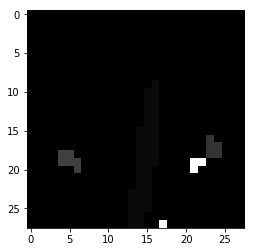

In [15]:
# Display some images from the testing 

plt.figure()
plt.imshow(images[49,0,:,:],cmap='gray')

In [16]:
noise=1/3 # Noise level to introduce in the reconstruction
test_data = generate_data(test_images,fwd_op_mod,noise_type='Poisson',noise_level=noise) # Provide noisy test images with Poisson distributed noise

In [17]:
mlem_test_10=mlem_op_comp_mod(test_data) # MLEM reconstruction of the test data with 10 iterations for further comparison

Text(0.5, 1.0, 'Test sinogram #1')

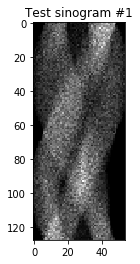

In [18]:
# See the sinograms of the test set

num=0

plt.figure()
plt.imshow(test_data[num,0,:,:].cpu(),cmap='gray')
plt.title('Test sinogram #'+str(num+1))



In [19]:
# DENOISING WITH ELLIPSOIDS:

use_cuda = True # Ellaborate the network in GPU
learning_rate = 1.5e-3 # Learning rate for the loss function
log_interval = 200 # Frequency of batches with which the code prints the training state of the network
epochs = 1 # Number of training iterations
denoise_net = UNet() # Denoising network model
loss_train = nn.SmoothL1Loss() # Use Mean Squared Error as loss function for the train images (Smooth L1 loss)
loss_test = nn.SmoothL1Loss() # Use Mean Squared Error as loss function for the test images (Smooth L1 loss)


if use_cuda: # Implement these operators with CUDA (model, validation sinograms and validation images)
    denoise_net = denoise_net.cuda()
    test_data = test_data.cuda()
    test_images = test_images.cuda()

optimizer = optim.Adam(denoise_net.parameters(), lr=learning_rate) # Use Adam as optimizer for the loss function with the denoising network parameters and the given learning rate


def train(epoch): # Function to perform network training
    denoise_net.train() # Set model into training
    for batch_idx,images in enumerate(train_loader): # Go through all training images according to the different batches used
        if use_cuda:
            images = images.cuda() # Transfer training images to the GPU
        projs = generate_data(images,fwd_op_mod,noise_type='Poisson',noise_level=1/3) # Add random Poisson noise to the train images
        noisy_recos = mlem_op_net_mod(projs) # Reconstruct the training images with the noise
        
        optimizer.zero_grad() # Clear the gradient results in the optimizer
        output = denoise_net(noisy_recos.cuda()) # Obtain the output of the first forward pass
        
        loss = loss_train(output, images.cuda().float()) # Compute the loss function with respect to some Ground Truth or target (the Ellipsoid Images)
        loss.backward() # Gradient accumulator
        optimizer.step() # Optimizer update
        if batch_idx % log_interval == 0: # Print the progress of the training according to the epoch number, the batch number and the loss function
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.6f}'
                  ''.format(epoch, batch_idx * len(images),
                            len(train_loader.dataset),
                            100. * batch_idx / len(train_loader),
                            loss))
        
        # Obtain data for ellaboration of learning curve plot: TRAINING ERROR of last batch
        if batch_idx==len(train_loader)-1:
            return loss.data


def test(): # Obtain validation results with the given trained network
    denoise_net.eval() # Set model into evaluation
    
    # 1 iteration MLEM reconstruction of validation data
    reco=mlem_op_net_mod(test_data)
    
    # Loss function computation with respect to validation ground truth
    loss = (loss_test(denoise_net(reco.cuda()), test_images.float()))
    print('\nTest set: Average loss: {:.6f}'.format(loss.data)) # Evaluate accuracy of test set with the loss function, as the targets of the test set are also known
    
    # Save test error for development of learning curve: VALIDATION ERROR
    return loss.data

In [20]:
train_error=[] # List with training errors for the development of the learning curve
test_error=[] # List with testing errors for the development of the learning curve

for epoch in range(1, epochs + 1): # Perform training and testing for the given number of epochs
    train_error.append(train(epoch)) # Train the network and compute the training error
    #clear_output()
    #test()
    test_error.append(test())  # Validate the network and compute the validation error

/opt/tljh/user/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Train Epoch: 1 [0/60000 (0%)]	Batch Loss: 0.052416


KeyboardInterrupt: 

Text(0, 0.5, 'Error')

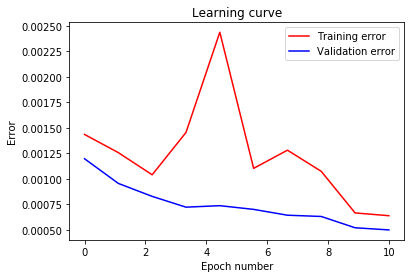

In [138]:
# Learning curve plot
plt.plot(np.linspace(0,epochs,epochs),train_error,'r',label='Training error') # Plotting training error in red
plt.plot(np.linspace(0,epochs,epochs),test_error,'b',label='Validation error') # Plotting validation error in blue
plt.legend()
plt.title('Learning curve')
plt.xlabel('Epoch number')
plt.ylabel('Error')

In [139]:
# Use the already trained and validated network to denoise test images with random ellipsoids


test_res_denoise = denoise_net(mlem_op_net_mod(test_data).cuda()).detach().cpu().numpy() # Obtained denoised results with the given network


In [175]:
# Save network models and parameters
# Save the whole model, including optimizer parameters (for further training for example)
torch.save({
            'epoch': epochs,
            'model_state_dict': denoise_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_train,
            }, 'denoiser_2d_28x28_ellipsoids.tar' )

# Save the model, without optimization parameters
torch.save(denoise_net, '2d_28x28_denoise.torch') # Save the trained and tested network


In [ ]:
# Load model checkpoint (just if you need it), including optimizer parameters UNCOMMENT IT IF YOU WANT TO ACTIVATE IT

#denoise_net = UNet() # Model to load
#optimizer = optim.Adam(denoise_net.parameters(), lr=learning_rate) # Optimizer to load

#checkpoint = torch.load('denoiser_2d_28x28_ellipsoids.tar') # Model checkpoint to save
#denoise_net.load_state_dict(checkpoint['model_state_dict']) # Load model state
#optimizer.load_state_dict(checkpoint['optimizer_state_dict']) # Load optimizer state
#epochs = checkpoint['epoch'] # Load epochs to work with
#loss_train = checkpoint['loss'] #  Load loss function

#denoise_net.train() # Set the model to train, if you wish to further train it

# Load the network without optimization parameters
#loaded_net = torch.load('denoise.torch') # Load the network

Text(0.5, 1.0, 'Test image profile #46')

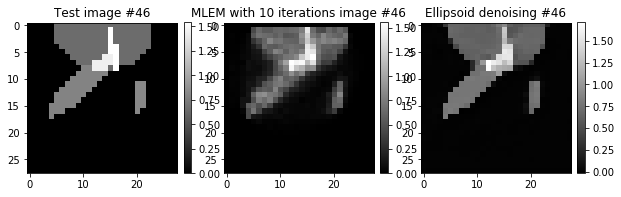

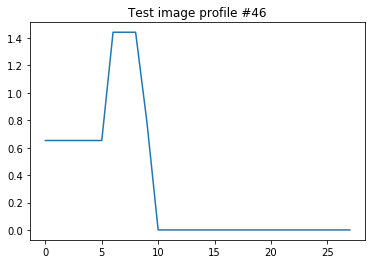

In [153]:
# RESULT VISUALIZATION

num=46 # Image number to visualize inside the validation batch

# Ground-truth image
plt.figure(figsize=(10,20))
plt.subplot(131)
plt.imshow(test_images[num,0,:,:].cpu(),cmap='gray')
plt.title('Test image #'+str(num))
plt.colorbar(fraction=0.046, pad=0.04)

# Image reconstructed with 10 iterations MLEM
plt.subplot(132)
plt.imshow(mlem_test_10[num,0,:,:].cpu(),cmap='gray')
plt.title('MLEM with 10 iterations image #'+str(num))
plt.colorbar(fraction=0.046, pad=0.04)

# Denoised image with neural network
plt.subplot(133)
plt.imshow(test_res_denoise[num,0,:,:],cmap='gray')
plt.title('Ellipsoid denoising #'+str(num))
plt.colorbar(fraction=0.046, pad=0.04)

plt.figure()
plt.plot(range(test_images.cpu().numpy().shape[2]),test_images.cpu().numpy().squeeze()[num,0:test_images.cpu().numpy().shape[2],int(test_images.cpu().numpy().shape[3]/2)])
plt.title('Test image profile #'+str(num))

In [104]:
# LOAD MNIST DATASET FOR TRAINING NAD COMPARE NETWORK RESULTS WITH ELLIPSOIDS NETWORK

dset_train_mnist = datasets.MNIST('./data', train=True, download=True, transform=trafo) # Download the MNIST images (handwritten numbers) for training as PyTorch tensors
train_loader_mnist = torch.utils.data.DataLoader(dset_train_mnist, batch_size=50, shuffle=True) # Load the MNIST images with a batch size of 50 and shuffling

# MNIST validation data (unused)

#dset_test_mnist = datasets.MNIST('./data', train=False, transform=trafo) # Obtain MNIST images (handwritten numbers) for testing as PyTorch tensors
#test_loader_mnist = torch.utils.data.DataLoader(dset_test, batch_size=50, shuffle=True) # Load the test images with a batch size of 50 (50 images tested per iteration) and shuffle them after every iteration

In [105]:
# Prepare the MNIST forward operator and MLEM reconstruction operator

space_mnist = odl.uniform_discr([-14, -14], [14, 14], [28, 28], dtype='float32') # Discretized space for the MNIST images, which defines their resolution (28x28)
geometry_mnist = odl.tomo.parallel_beam_geometry(space_mnist, num_angles=54) # Define the geometry. In this case, parallel-beam with 54 views. Emulate 
fwd_op_mnist = odl.tomo.RayTransform(space_mnist, geometry_mnist) # Define the forward operator as the Radon Transform
fwd_op_mnist_mod=OperatorAsModule(fwd_op_mnist) # Forward operator to work with tensors

In [106]:
# Class for performing MLEM reconstruction in MNIST images
class MLEM_mnist(odl.operator.Operator):
    def __init__(self, op, niter):
        super(MLEM_mnist, self).__init__(domain=fwd_op_mnist.range, range=fwd_op_mnist.domain, linear=True) # Define the MNIST images reconstruction space
        self.op = op
        self.niter = niter # Set the number of iterations
    
    def _call(self, data):
        reco = self.range.one() # MNIST images reconstruction space
        odl.solvers.iterative.statistical.mlem(self.op, reco, data, niter=self.niter) # MLEM function from ODL
        return reco

In [107]:
# MLEM reconstruction operators for MNIST images

mlem_op_net_mnist=MLEM_mnist(fwd_op_mnist,niter=1) # MLEM operator. 1 iteration
mlem_op_net_mnist_mod=OperatorAsModule(mlem_op_net_mnist) # Modified MLEM operator to work with torch tensors

mlem_op_comp_mnist=MLEM_mnist(fwd_op_mnist,niter=10) # MLEM operator. 10 iterations
mlem_op_comp_mnist_mod=OperatorAsModule(mlem_op_net_mnist) # Modified MLEM operator to work with torch tensors

In [108]:
use_cuda = True # Construct the network in the GPU
learning_rate = 1.5e-3 # Learning rate for the loss function
log_interval = 200 # Frequency of batches after we print a message of state of the network
epochs = 10 # Number of training iterations
denoise_net_mnist = UNet() # Denoising network operator
loss_train_mnist = nn.SmoothL1Loss() # Use Mean Squared Error as loss function for the train images (L1 loss)
loss_test_mnist = nn.SmoothL1Loss() # Use Mean Squared Error as loss function for the test images (L1 loss)

#if use_cuda: # Implement these operators with CUDA
    #denoise_net = denoise_net.cuda()
    #test_data = test_data.cuda()
    #test_images = test_images.cuda()

optimizer = optim.Adam(denoise_net.parameters(), lr=learning_rate) # Use Adam as optimizer for the loss function with the denoising network parameters and the given learning rate


def train_mnist(epoch): # Function to perform network training
    denoise_net_mnist.train() # Set network to train
    for batch_idx,images_mnist in enumerate(train_loader_mnist): # Go through all training images according to the different batches used
        if use_cuda:
            images_mnist = images_mnist[0].cuda() # Transfer training images to the GPU
        projs = generate_data(images_mnist,fwd_op_mnist_mod,noise_type='Gaussian',noise_level=1/3) # Add random Poisson noise to the train images
        noisy_recos = mlem_op_net_mnist_mod(projs) # Reconstruct the training images with the noise
        optimizer.zero_grad() # Set to zero the optimizer parameters for a new batch
        output = denoise_net_mnist(noisy_recos) # Obtain the output of the first forward pass
        loss = loss_train(output, images_mnist.float().cpu()) # Compute the loss function with respect to some Ground Truth or target
        loss.backward() # Start back-propagation
        optimizer.step() # Define some optimizer step
        if batch_idx % log_interval == 0: # Print the progress of the training according to the epoch number, the batch number and the loss function
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.6f}'
                  ''.format(epoch, batch_idx * len(images_mnist),
                            len(train_loader.dataset),
                            100. * batch_idx / len(train_loader_mnist),
                            loss))
        if batch_idx == len(train_loader_mnist)-1:
            return loss.data

def test_mnist(): # Obtain test results with the given trained network
    denoise_net_mnist.eval() # Set network to validate
 
    loss = (loss_train_mnist(denoise_net_mnist(mlem_op_net_mod(test_data.cpu()).float()), test_images.cpu().float())) # Loss function to compare to the original validation ground truth
    print('\nTest set: Average loss: {:.6f}'.format(loss.data)) # Evaluate accuracy of test set with the loss function, as the targets of the test set are also known
    return loss.data

In [109]:
train_mnist_error=[] # List with training errors for the development of the learning curve
test_mnist_error=[] # List with testing errors for the development of the learning curve

for epoch in range(1, epochs + 1): # Perform training and testing for the given number of epochs
    train_mnist_error.append(train_mnist(epoch)) # Train the network and compute training error
    #clear_output()
    test_mnist_error.append(test_mnist()) # Validate the network and compute validation error

Train Epoch: 1 [0/60000 (0%)]	Batch Loss: 0.083162
Train Epoch: 1 [10000/60000 (17%)]	Batch Loss: 0.084285
Train Epoch: 1 [20000/60000 (33%)]	Batch Loss: 0.081311
Train Epoch: 1 [30000/60000 (50%)]	Batch Loss: 0.083509
Train Epoch: 1 [40000/60000 (67%)]	Batch Loss: 0.079797
Train Epoch: 1 [50000/60000 (83%)]	Batch Loss: 0.086096

Test set: Average loss: 0.118906
Train Epoch: 2 [0/60000 (0%)]	Batch Loss: 0.092321
Train Epoch: 2 [10000/60000 (17%)]	Batch Loss: 0.086581
Train Epoch: 2 [20000/60000 (33%)]	Batch Loss: 0.087874
Train Epoch: 2 [30000/60000 (50%)]	Batch Loss: 0.085426
Train Epoch: 2 [40000/60000 (67%)]	Batch Loss: 0.078655
Train Epoch: 2 [50000/60000 (83%)]	Batch Loss: 0.086935

Test set: Average loss: 0.116818
Train Epoch: 3 [0/60000 (0%)]	Batch Loss: 0.091920
Train Epoch: 3 [10000/60000 (17%)]	Batch Loss: 0.086320
Train Epoch: 3 [20000/60000 (33%)]	Batch Loss: 0.087922
Train Epoch: 3 [30000/60000 (50%)]	Batch Loss: 0.085315
Train Epoch: 3 [40000/60000 (67%)]	Batch Loss: 0.07

Text(0, 0.5, 'Error')

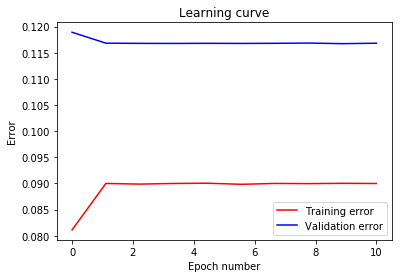

In [128]:
# Learning curve plot
plt.plot(np.linspace(0,epochs,epochs),train_mnist_error,'r',label='Training error') # Plotting training error in red
plt.plot(np.linspace(0,epochs,epochs),test_mnist_error,'b',label='Validation error') # Plotting validation error in blue
plt.legend()
plt.title('Learning curve')
plt.xlabel('Epoch number')
plt.ylabel('Error')

In [129]:
# Normalize the test data values so to introduce inputs between -1 and +1 in the network



test_res_denoise_mnist = denoise_net_mnist(mlem_op_net_mod(test_data.cpu()).float()).detach().cpu().numpy() # Obtained denoised results with the given network trained with MNIST images

# Set to 0 negative values
ind_0=np.where(test_res_denoise_mnist<0)
test_res_denoise_mnist[ind_0]=0.0

ind_0=np.where(test_res_denoise<0)
test_res_denoise[ind_0]=0.0

In [176]:
# Save checkpoint used in network
# Save the whole model (for further training for example), including the optimizer
torch.save({
            'epoch': epochs,
            'model_state_dict': denoise_net_mnist.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_train,
            }, 'denoiser_2d_28x28_mnist.tar' )

# Save the model without the optimizer 
torch.save(denoise_net_mnist, '2d_28x28_denoise_mnist.torch') # Save the trained and tested network

In [ ]:
# Load model checkpoint (just if you need it) UNCOMMENT IT IF YOU WANT TO ACTIVATE IT

#denoise_net_mnist = UNet() # Network model to be loaded
#optimizer = optim.Adam(denoise_net_mnist.parameters(), lr=learning_rate) # Optimizer to be loaded

#checkpoint = torch.load('denoiser_2d_28x28_ellipsoids.tar') # Loading the network from where it was last trained
#denoise_net.load_state_dict(checkpoint['model_state_dict']) # Load network state
#optimizer.load_state_dict(checkpoint['optimizer_state_dict']) # Load optimizer state
#epochs = checkpoint['epoch'] # Load epochs
#loss_train = checkpoint['loss'] # Load loss function

#denoise_net_mnist.train()

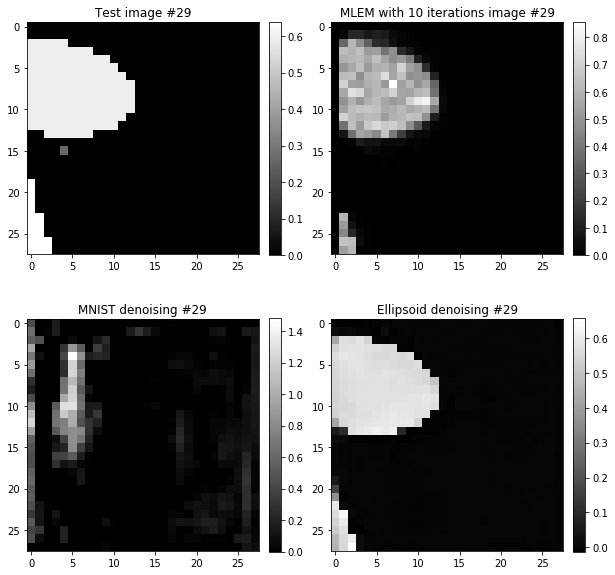

In [171]:
# RESULT VISUALIZATION WITH BOTH NETWORKS

num=28 # Image to visualize


plt.figure(figsize=(10,10))

# Ground truth
plt.subplot(221)
plt.imshow(test_images[num,0,:,:].cpu(),cmap='gray')
plt.title('Test image #'+str(num+1))
plt.colorbar(fraction=0.046, pad=0.04)


# 10 iterations MLEM reconstruction
plt.subplot(222)
plt.imshow(mlem_test_10[num,0,:,:].cpu(),cmap='gray')
plt.title('MLEM with 10 iterations image #'+str(num+1))
plt.colorbar(fraction=0.046, pad=0.04)

# Denoising with MNIST images
plt.subplot(223)
plt.imshow(test_res_denoise_mnist[num,0,:,:],cmap='gray')
plt.title('MNIST denoising #'+str(num+1))
plt.colorbar(fraction=0.046, pad=0.04)

# Denoising with random ellipsoids
plt.subplot(224)
plt.imshow(test_res_denoise[num,0,:,:],cmap='gray')
plt.title('Ellipsoid denoising #'+str(num+1))
plt.colorbar(fraction=0.046, pad=0.04)



In [159]:
# NORMALIZATION OF IMAGES (compare profiles with the same dynamic range between 0 and 1) (actually unused)
test_images_norm=np.copy(test_images.cpu().numpy().squeeze())
mlem_10_norm=np.copy(mlem_test_10.cpu().numpy().squeeze())
denoised_norm=np.copy(test_res_denoise.squeeze())
denoised_norm_mnist=np.copy(test_res_denoise_mnist.squeeze())
#for i in range(test_images.shape[0]):
    #test_images_norm[i,:,:]=test_images_norm[i,:,:]/np.amax(test_images_norm[i,:,:].flatten())
    #mlem_10_norm[i,:,:]=mlem_10_norm[i,:,:]/np.amax(mlem_10_norm[i,:,:].flatten())
    #denoised_norm[i,:,:]=denoised_norm[i,:,:]/np.amax(denoised_norm[i,:,:].flatten())




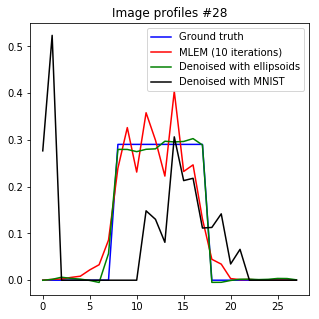

In [174]:
# See the profiles of the center column of each validation image
num=27


plt.figure(figsize=(5,5))
plt.plot(range(test_images_norm.shape[2]),test_images_norm[num,0:test_images_norm.shape[1],int(test_images_norm.shape[2]/2)],'b',label='Ground truth') # Ground truth profile
plt.title('Image profiles #'+str(num+1))
plt.plot(range(test_images_norm.shape[2]),mlem_10_norm[num,0:test_images_norm.shape[1],int(test_images_norm.shape[2]/2)],'r',label='MLEM (10 iterations)') # 10 iterations MLEM reconstruction profile
plt.plot(range(test_images_norm.shape[2]),denoised_norm[num,0:test_images_norm.shape[1],int(test_images_norm.shape[2]/2)].squeeze(),'g',label='Denoised with ellipsoids') # Profile from images denoised with random ellipsoids
plt.plot(range(test_images_norm.shape[2]),denoised_norm_mnist[num,0:test_images_norm.shape[1],int(test_images_norm.shape[2]/2)].squeeze(),'k',label='Denoised with MNIST') # Profile from images denoised with MNIST database 
plt.legend()

In [133]:
def peak_SNR(img,ground_truth):
    # Compute the peak SNR (PSNR) between an image and its ground truth
    
    # Normalization: make both images have a maximum value of 1
    img=torch.tensor(img/np.amax(img.flatten()))
    ground_truth=torch.tensor(ground_truth/np.amax(ground_truth.flatten()))
    
    mse=nn.MSELoss() # Define the Mean Square Error
    return -10*np.log10(mse(img,ground_truth.float())) # PSNR definition

In [172]:
# FIGURE OF MERIT EVALUATION: SSIM & PSNR FOR ALL THE VALIDATION BATCH

# Compare the results with the Structural Similarity Index 

mlem_ssim=fom.ssim(mlem_10_norm,test_images_norm) # SSIM for the MLEM reconstructed images
mnist_ssim=fom.ssim(test_res_denoise_mnist.squeeze(),test_images.cpu().numpy().squeeze()) # SSIM for the denoised images with the MNIST network
ellipses_ssim=fom.ssim(denoised_norm,test_images_norm) # SSIM for the denoised images with the ellipsoid network


# Compare the results with the Peak Signal-to-Noise Ratio

mlem_psnr=peak_SNR(mlem_10_norm,test_images_norm) # SSIM for the MLEM reconstructed images
mnist_psnr=peak_SNR(test_res_denoise_mnist.squeeze(),test_images.cpu().numpy().squeeze()) # SSIM for the denoised images with the MNIST network
ellipses_psnr=peak_SNR(denoised_norm,test_images_norm) # SSIM for the denoised images with the ellipsoid network

# Print all results

print('\nSSIM for MLEM reconstructed images with 10 iterations: {}'.format(mlem_ssim))
print('\nSSIM for denoised images with MNIST network: {}'.format(mnist_ssim))
print('\nSSIM for denoised images with ellipsoids network: {}\n'.format(ellipses_ssim))


print('\nPSNR for MLEM reconstructed images with 10 iterations: {}'.format(mlem_psnr))
print('\nPSNR for denoised images with MNIST network: {}'.format(mnist_psnr))
print('\nPSNR for denoised images with ellipsoids network: {}\n'.format(ellipses_psnr))


SSIM for MLEM reconstructed images with 10 iterations: 0.9502404399576362

SSIM for denoised images with MNIST network: 0.07982201114179095

SSIM for denoised images with ellipsoids network: 0.9915505930091472


PSNR for MLEM reconstructed images with 10 iterations: 26.731304168701172

PSNR for denoised images with MNIST network: 17.07815170288086

PSNR for denoised images with ellipsoids network: 35.45164489746094



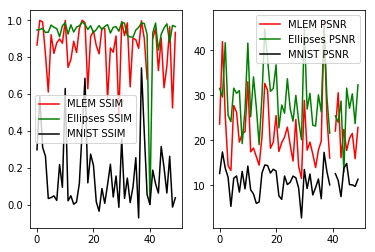

In [173]:
# Evaluate the SSIM and the PSNR image by image in the validation batch
mnist_ssim_list=[] # SSIM values in images denoised with the MNIST network
mlem_ssim_list=[] # SSIM values in images reconstructed with 10 iterations MLEM
ellipses_ssim_list=[] # SSIM values in images denoised with the ellipsoid network

mnist_psnr_list=[] # PSNR values in images denoised with the MNIST network
mlem_psnr_list=[] # PSNR values in images reconstructed with 10 iterations MLEM
ellipses_psnr_list=[] # PSNR values in images denoised with the ellipsoid network

for i in range(test_images_norm.shape[0]): # Go image by image computing the SSIM and the PSNR
    mlem_ssim_list.append(fom.ssim(mlem_10_norm[i,:,:],test_images_norm[i,:,:]))
    ellipses_ssim_list.append(fom.ssim(denoised_norm[i,:,:],test_images_norm[i,:,:]))
    mnist_ssim_list.append(fom.ssim(denoised_norm_mnist[i,:,:],test_images_norm[i,:,:]))
    mlem_psnr_list.append(peak_SNR(mlem_10_norm[i,:,:],test_images_norm[i,:,:]))
    ellipses_psnr_list.append(peak_SNR(denoised_norm[i,:,:],test_images_norm[i,:,:]))
    mnist_psnr_list.append(peak_SNR(denoised_norm_mnist[i,:,:],test_images_norm[i,:,:]))

plt.figure()
plt.subplot(1,2,1)
plt.plot(range(test_images_norm.shape[0]),mlem_ssim_list,'r',label='MLEM SSIM')
plt.plot(range(test_images_norm.shape[0]),ellipses_ssim_list,'g',label='Ellipses SSIM')
plt.plot(range(test_images_norm.shape[0]),mnist_ssim_list,'k',label='MNIST SSIM')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(test_images_norm.shape[0]),mlem_psnr_list,'r',label='MLEM PSNR')
plt.plot(range(test_images_norm.shape[0]),ellipses_psnr_list,'g',label='Ellipses PSNR')
plt.plot(range(test_images_norm.shape[0]),mnist_psnr_list,'k',label='MNIST PSNR')
plt.legend()

